In [1]:
import numpy as np
import os
import glob
import scipy.ndimage as ndimage
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pyplot as plt
from skimage import feature, exposure, filters
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, confusion_matrix

In [2]:
directory_path = './data/cells'
image_files = [f for f in glob.glob(os.path.join(directory_path, '*')) if 'Edges' not in os.path.basename(f)]
images = np.array([np.array(Image.open(filename).convert('L'), dtype=np.float32) for filename in image_files])

ground_truth_image_files = [f for f in glob.glob(os.path.join(directory_path, '*')) if 'Edges' in os.path.basename(f)]
ground_truths = np.array([np.array(Image.open(filename).convert('L'), dtype=np.float32) for filename in ground_truth_image_files])

In [108]:
def compute_gradients(images, edge_type, apply_blur_gauss=False, blur_sigma=0):
    def compute_edge_strength(src, method):
        edges = None

        if method == "Roberts":
            gx_mask = np.array([[1, 0 ], [0,-1 ]])
            gy_mask = np.array([[ 0, 1 ], [ -1, 0 ]])

            vertical = ndimage.convolve(src, gx_mask)
            horizontal = ndimage.convolve(src, gy_mask)

            edges = np.sqrt(vertical**2 + horizontal**2)
            edges = edges.astype(np.uint8)

        elif method == "Sobel":
            kdepth = cv.CV_32F
            grad_x = cv.Sobel(src, kdepth, 1, 0)    
            grad_y = cv.Sobel(src, kdepth, 0, 1)
            grad = np.sqrt(grad_x**2 + grad_y**2)
            edges = (grad * 255 / grad.max()).astype(np.uint8)


        elif method == "First Order Gaussian":
            gx_mask = np.array([[-1, 1 ], [-1, 1]])
            gy_mask = np.array([[ 1, 1 ], [ -1, -1 ]])

            src = filters.gaussian(src, sigma=1)

            vertical = ndimage.convolve(src, gx_mask)
            horizontal = ndimage.convolve(src, gy_mask)
            
            edges = np.sqrt(vertical**2 + horizontal**2)
            edges = edges.astype(np.uint8)
            
        elif method == "Laplacian":
            edges = filters.laplace(image=src)

        elif method == "Laplacian of Gaussian":
            edges = filters.gaussian(image=src, sigma=blur_sigma)
            edges = filters.laplace(image=edges)

        elif method == "Canny":
            # This has to be done in the threshold method to expose
            # the threshold parameters so they can be changed for ROC;
            # this kind of ruins everything
            return edges

        return edges

        """if edge_type == "Laplacian" or edge_type == "Laplacian of Gaussian":
            # Detect zero crossings
            edges = np.pad(edges, ((0, 1), (0, 1)))
            
            gx_mask = np.where(edges[:-1, :-1] - edges[:-1, 1:] < 0, 1, 0)
            gy_mask = np.where(edges[:-1, :-1] - edges[1:, :-1] < 0, 1, 0)

            edges =  (gx_mask|gy_mask).astype(float)"""

        
    
    gradients = []

    for img in images:
        if apply_blur_gauss:
            img = ndimage.gaussian_filter(img, blur_sigma)

        edge_strength = compute_edge_strength(img, edge_type)
        gradients.append(edge_strength)
    
    return np.asarray(gradients)

In [246]:
def apply_threshold(images, gradients, technique, threshold, canny_sigma = 0):

    def variance_threshold(src, edges, threshold):
        win_mean = ndimage.uniform_filter(src, (5, 5))
        win_sqr_mean = ndimage.uniform_filter(src**2, (5, 5))
        win_var = win_sqr_mean - win_mean**2

        scaled_var = ((win_var - win_var.min()) / 
               (win_var.max() - win_var.min())) * (255)

        modified_edges = np.where((scaled_var < threshold) & (edges == 0), 1, edges)
        modified_edges = np.where((scaled_var >= threshold) & (edges == 0), 0, modified_edges)
        
        return modified_edges

    def detect_zero_crossings_with_magnitude(edges, magnitude_threshold=10):

        edges_padded = np.pad(edges, ((0, 1), (0, 1)), mode='constant', constant_values=0)

        gx_diff = np.abs(edges_padded[:-1, :-1] - edges_padded[:-1, 1:])
        gy_diff = np.abs(edges_padded[:-1, :-1] - edges_padded[1:, :-1])

        gx_diff_normalized = np.interp(gx_diff, (gx_diff.min(), gx_diff.max()), (0, 255))
        gy_diff_normalized = np.interp(gy_diff, (gy_diff.min(), gy_diff.max()), (0, 255))
        
        gx_crossings = np.where((edges_padded[:-1, :-1] * edges_padded[:-1, 1:] < 0) & 
                                (gx_diff_normalized > magnitude_threshold), 1, 0)
        gy_crossings = np.where((edges_padded[:-1, :-1] * edges_padded[1:, :-1] < 0) & 
                                (gy_diff_normalized > magnitude_threshold), 1, 0)

        edges_detected = (gx_crossings | gy_crossings).astype(np.uint8)

        return edges_detected

    thresholded_images = []

    def sobel_magnitudes(edges, magnitude_threshold):
        kdepth = cv.CV_32F
        grad_x = cv.Sobel(edges, kdepth, 1, 0)    
        grad_y = cv.Sobel(edges, kdepth, 0, 1)
        grad = np.sqrt(grad_x**2 + grad_y**2)
        edges = (grad * 255 / grad.max()).astype(np.uint8)

        # And then threshold
        _, edges = cv.threshold(edges, magnitude_threshold, 255, cv.THRESH_BINARY)

        print(edges)
        return edges

    for i in range(len(gradients)):
        if technique in ['Laplacian', 'Laplacian of Gaussian']:
            binary_image = detect_zero_crossings_with_magnitude(gradients[i], threshold)
            binary_image = (binary_image*255).astype(np.uint8)
            #binary_image = sobel_magnitudes(gradients[i], threshold)

        elif technique == 'Canny':
            high_threshold = threshold
            low_threshold = high_threshold*0.75
            
            if high_threshold < 0:
                high_threshold = 0
                low_threshold = 0
            
            binary_image = feature.canny(images[i], sigma=canny_sigma, low_threshold=low_threshold, high_threshold=high_threshold)
        
        else:
            _, binary_image = cv.threshold(gradients[i], threshold, 255, cv.THRESH_BINARY)
            
        binary_image = ~binary_image
        thresholded_images.append(binary_image)

    return np.asarray(thresholded_images)

In [207]:
def display_processed_images(processed_images):
    n = len(processed_images)
    cols = 3
    rows = n // cols + (1 if n % cols else 0)
    
    plt.figure(figsize=(15, rows * 5)) 
    
    for i, image in enumerate(processed_images, start=1):
        plt.subplot(rows, cols, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

132432
0
(1.0, 1.0, 0.10103759765625, 1.0, 0.18353160304666452)


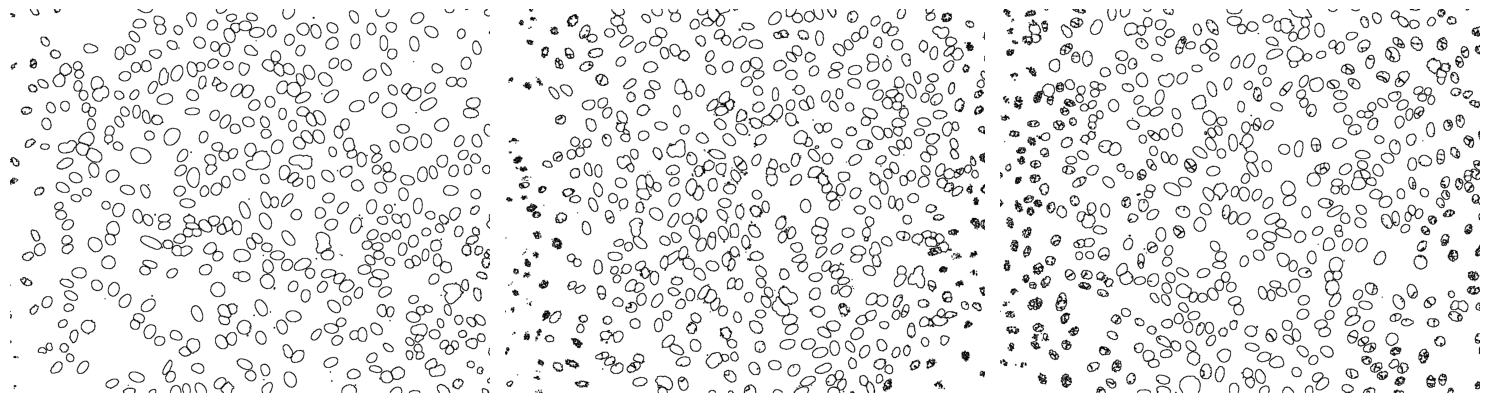

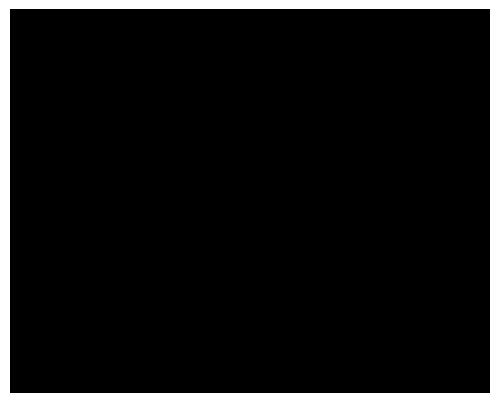

In [297]:
def calc_performance_metrics(ground_truth, predictions):

    flattened_ground_truths = ground_truth.flatten()
    flattened_edge_detected = predictions.flatten()

    inverted_flattened_ground_truths = (flattened_ground_truths == 0).astype(int)
    inverted_flattened_edge_detected = (flattened_edge_detected == 0).astype(int)

    tp = ((inverted_flattened_ground_truths == 1) & (inverted_flattened_edge_detected == 1)).sum()
    tn = ((inverted_flattened_ground_truths == 0) & (inverted_flattened_edge_detected == 0)).sum()
    fp = ((inverted_flattened_ground_truths == 0) & (inverted_flattened_edge_detected == 1)).sum()
    fn = ((inverted_flattened_ground_truths == 1) & (inverted_flattened_edge_detected == 0)).sum()

    if (tp+fp) == 0:
        print(tp)
        print(fp)

    print(tp)
    print(fn)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    #print(precision)
    recall = tp / (tp + fn)
    #print(recall)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return tpr, fpr, precision, recall, f1_score


edge_type = 'Sobel'
threshold = -1
gradients = compute_gradients([images[2]], edge_type=edge_type, apply_blur_gauss=False, blur_sigma=1)
thresholded_images = apply_threshold([images[2]], gradients, technique=edge_type, threshold=threshold, canny_sigma=1)

print(calc_performance_metrics(ground_truth=ground_truths[2], predictions=thresholded_images))

#print(np.unique(thresholded_images))

display_processed_images(processed_images=ground_truths)
display_processed_images(processed_images=thresholded_images)

Laplacian
Method: Laplacian, Image: 1, Best Threshold: 11.0, TPR: 0.40919491196773444, FPR: 0.18635514452092455
Laplacian of Gaussian
Method: Laplacian of Gaussian, Image: 1, Best Threshold: 10.5, TPR: 0.32586481036221204, FPR: 0.04047281496154279
Sobel
Method: Sobel, Image: 1, Best Threshold: 24.0, TPR: 0.9012545567362135, FPR: 0.12052077881640576
First Order Gaussian
Method: First Order Gaussian, Image: 1, Best Threshold: 7.0, TPR: 0.9098347940743039, FPR: 0.1377619296839288
Roberts
Method: Roberts, Image: 1, Best Threshold: 5.0, TPR: 0.9018653532924843, FPR: 0.1571321390951791
Canny
Method: Canny, Image: 1, Best Threshold: 44.0, TPR: 0.34940471573722176, FPR: 0.011026221123970665


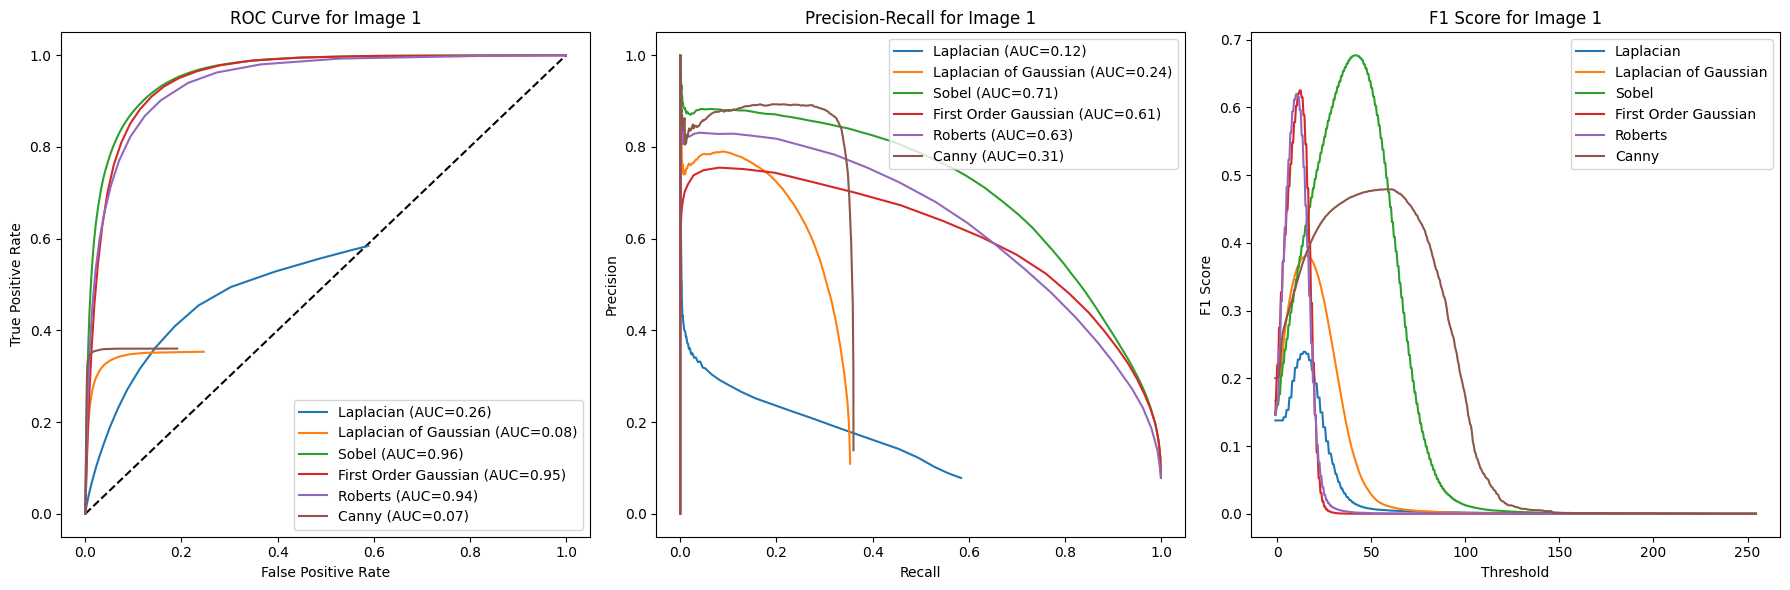

Laplacian
Method: Laplacian, Image: 2, Best Threshold: 14.0, TPR: 0.3809386921086776, FPR: 0.2264779709799164
Laplacian of Gaussian
Method: Laplacian of Gaussian, Image: 2, Best Threshold: 7.0, TPR: 0.2910240771961992, FPR: 0.07921936296593342
Sobel
Method: Sobel, Image: 2, Best Threshold: 11.0, TPR: 0.8483657185477542, FPR: 0.20440707304259104
First Order Gaussian
Method: First Order Gaussian, Image: 2, Best Threshold: 2.0, TPR: 0.8065744186588559, FPR: 0.1647136358521805
Roberts
Method: Roberts, Image: 2, Best Threshold: 2.0, TPR: 0.7829944604579251, FPR: 0.19844941958986775
Canny
Method: Canny, Image: 2, Best Threshold: 19.0, TPR: 0.2774044176488412, FPR: 0.02152860088205758


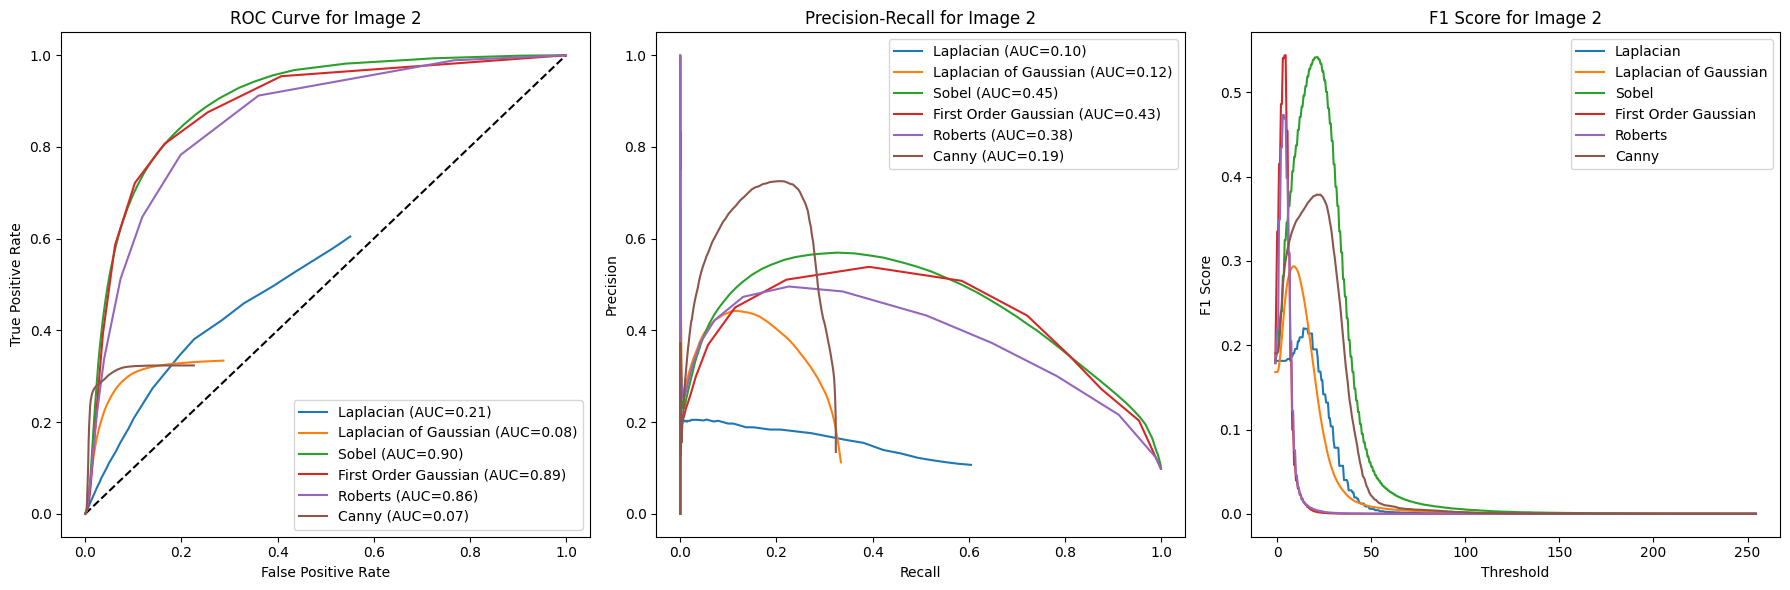

Laplacian
Method: Laplacian, Image: 3, Best Threshold: 16.5, TPR: 0.43833061495711007, FPR: 0.1853621525467458
Laplacian of Gaussian
Method: Laplacian of Gaussian, Image: 3, Best Threshold: 10.0, TPR: 0.3580781080101486, FPR: 0.06009821028475212
Sobel
Method: Sobel, Image: 3, Best Threshold: 22.0, TPR: 0.9452171680560589, FPR: 0.20426669880368806
First Order Gaussian
Method: First Order Gaussian, Image: 3, Best Threshold: 3.0, TPR: 0.9209934154887036, FPR: 0.22865886778105182
Roberts
Method: Roberts, Image: 3, Best Threshold: 3.0, TPR: 0.9339283556844267, FPR: 0.2132492226009261
Canny
Method: Canny, Image: 3, Best Threshold: 14.5, TPR: 0.33822641053521807, FPR: 0.045796104178265414


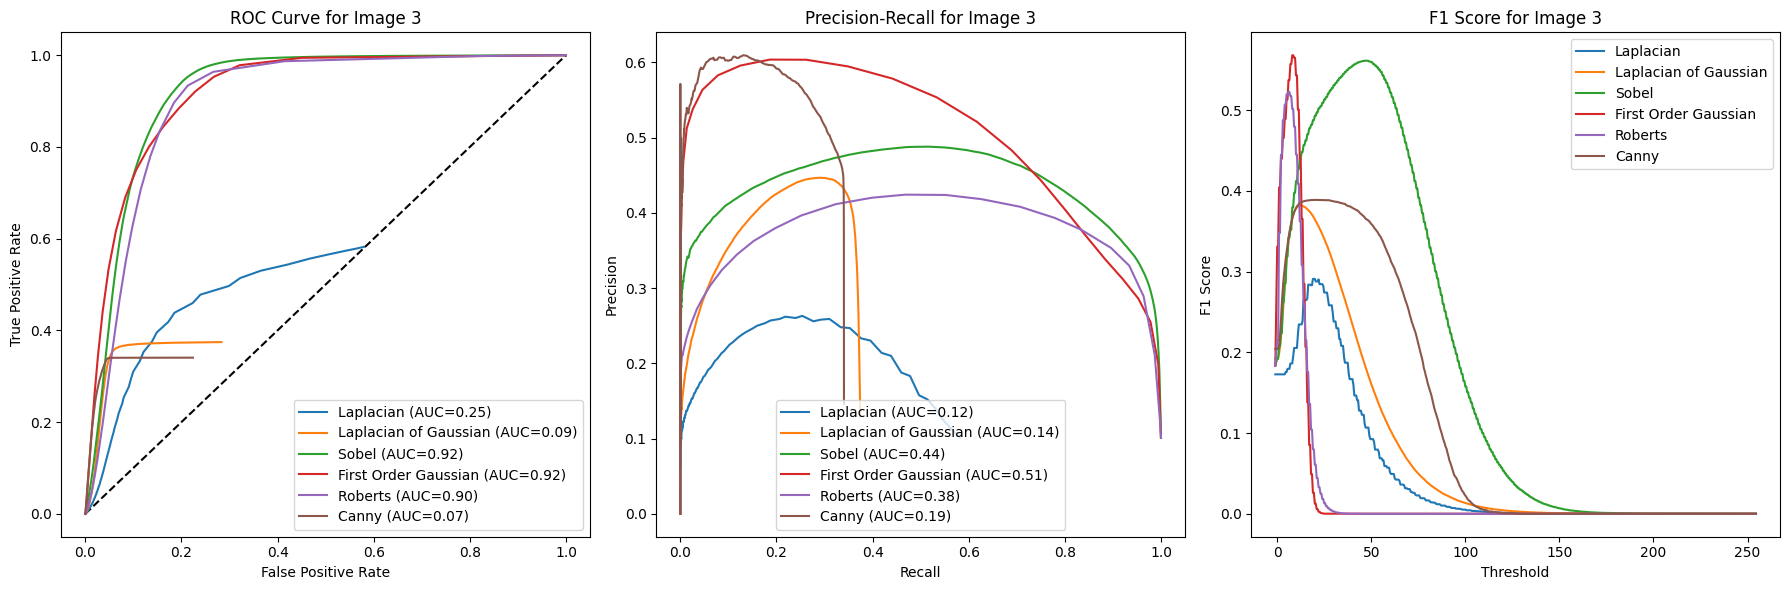

In [298]:
methods_settings = [
    {"name": "Laplacian", "apply_blur_gauss": False, "blur_sigma": 1},
    {"name": "Laplacian of Gaussian", "apply_blur_gauss": True, "blur_sigma": 1},
    {"name": "Sobel", "apply_blur_gauss": False, "blur_sigma": 1},
    {"name": "First Order Gaussian", "apply_blur_gauss": True, "blur_sigma": 1},
    {"name": "Roberts", "apply_blur_gauss": False, "blur_sigma": 1},
    {"name": "Canny", "apply_blur_gauss": False, "blur_sigma": 1}
]


method_gradients = {method_setting["name"]: None for method_setting in methods_settings}

for method_setting in methods_settings:
    method_gradients[method_setting["name"]] = compute_gradients(
        images, 
        edge_type=method_setting["name"], 
        apply_blur_gauss=method_setting["apply_blur_gauss"], 
        blur_sigma=method_setting["blur_sigma"]
    )

def find_best_threshold(tprs, fprs, thresholds):
    closest_idx = np.argmin(np.abs(1 - np.array(tprs)) + np.array(fprs))
    return thresholds[closest_idx], fprs[closest_idx], tprs[closest_idx]

def calc_performance_metrics(ground_truth, predictions):

    flattened_ground_truths = ground_truth.flatten()
    flattened_edge_detected = predictions.flatten()

    inverted_flattened_ground_truths = (flattened_ground_truths == 0).astype(int)
    inverted_flattened_edge_detected = (flattened_edge_detected == 0).astype(int)

    tp = ((inverted_flattened_ground_truths == 1) & (inverted_flattened_edge_detected == 1)).sum()
    tn = ((inverted_flattened_ground_truths == 0) & (inverted_flattened_edge_detected == 0)).sum()
    fp = ((inverted_flattened_ground_truths == 0) & (inverted_flattened_edge_detected == 1)).sum()
    fn = ((inverted_flattened_ground_truths == 1) & (inverted_flattened_edge_detected == 0)).sum()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return tpr, fpr, precision, recall, f1_score

ground_truth_binary = np.array(ground_truths).astype(int).flatten()

thresholds = [-1] + list(np.arange(0, 255, 0.5))

for image_index, (image, ground_truth) in enumerate(zip(images, ground_truths)):
    plt.figure(figsize=(18, 6))
    ground_truth_binary = np.array(ground_truth).astype(int).flatten()

    plt.subplot(1, 3, 1)
    plt.title(f'ROC Curve for Image {image_index+1}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.subplot(1, 3, 2)
    plt.title(f'Precision-Recall for Image {image_index+1}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.subplot(1, 3, 3)
    plt.title(f'F1 Score for Image {image_index+1}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')

    # Iterate through each method to plot the metrics using pre-computed gradients
    for method_setting in methods_settings:
        print(method_setting["name"])
        gradients = method_gradients[method_setting["name"]][image_index]  # Use pre-computed gradients
        
        tprs, fprs, precisions, recalls, f1_scores = [], [], [], [], []
        
        #if (method_setting["name"] == "Laplacian") or (method_setting["name"] == "Laplacian of Gaussian") or (method_setting["name"] == "Canny"):
            #tprs.append(1)
            #fprs.append(1)

        for threshold in thresholds:
            thresholded_image = apply_threshold([image], [gradients], technique=method_setting["name"], threshold=threshold, canny_sigma=1)[0]
            tpr, fpr, precision, recall, f1_score = calc_performance_metrics(ground_truth_binary, thresholded_image.flatten())

            tprs.append(tpr)
            fprs.append(fpr)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1_score)

        # Plot for this method
        roc_auc = auc(fprs, tprs)
        auprc = auc(recalls, precisions)
        best_threshold, best_fpr, best_tpr = find_best_threshold(tprs, fprs, thresholds)

        print(f'Method: {method_setting["name"]}, Image: {image_index+1}, Best Threshold: {best_threshold}, TPR: {best_tpr}, FPR: {best_fpr}')


        plt.subplot(1, 3, 1)
        plt.plot(fprs, tprs, label=f'{method_setting["name"]} (AUC={roc_auc:.2f})')

        plt.subplot(1, 3, 2)
        plt.plot(recalls, precisions, label=f'{method_setting["name"]} (AUC={auprc:.2f})')

        plt.subplot(1, 3, 3)
        plt.plot(thresholds, f1_scores, label=f'{method_setting["name"]}')


    # Add legends
    for i in range(1, 4):
        plt.subplot(1, 3, i)
        plt.legend()
    
    plt.tight_layout()
    plt.show()